In [74]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Skipping, found downloaded files in "./quran-recitations-for-audio-classification" (use force=True to force download)


In [75]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import time

from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from torchsummary import summary

from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [76]:
data_df = pd.read_csv("quran-recitations-for-audio-classification/files_paths.csv")
data_df["FilePath"] = "quran-recitations-for-audio-classification/Dataset" + data_df["FilePath"].str[1:]
data_df.head()

,FilePath,Class
0,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
1,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
2,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
3,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan
4,quran-recitations-for-audio-classification/Dat...,Mohammed_Aluhaidan


Class:  ['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
Class count:  12
DataPath:  quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_367.wav
Data Shape: (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


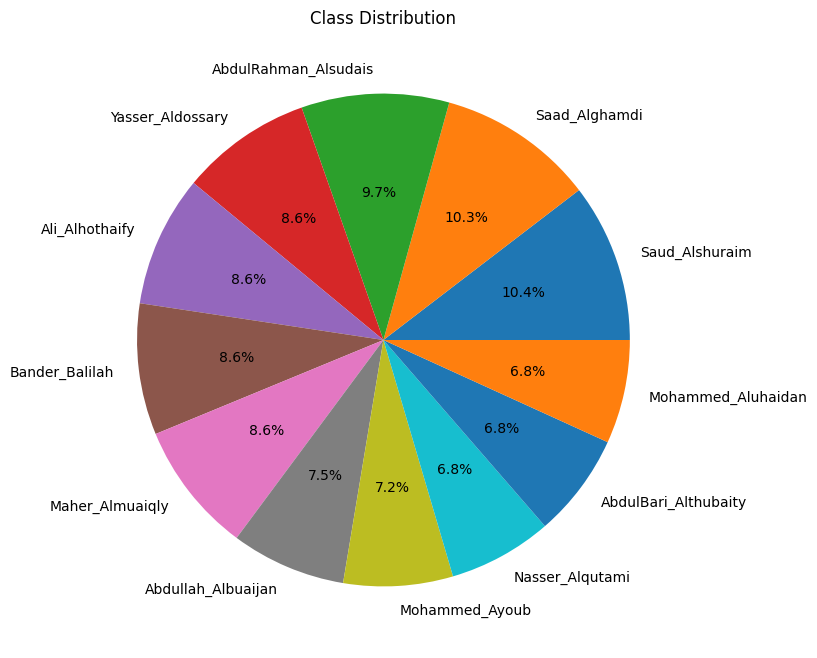

In [77]:
print(f"Class: ", data_df["Class"].unique())
print(f"Class count: ", len(data_df["Class"].unique()))
print(f"DataPath: ", data_df.iloc[3, 0])
print(f"Data Shape: {data_df.shape}")
print(f"Class Distribution: ", data_df["Class"].value_counts())

plt.figure(figsize=(8, 8))

plt.pie(data_df["Class"].value_counts(), labels=data_df["Class"].value_counts().index, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

In [78]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=7)
test = test.drop(val.index)


print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)
print("Val Shape: ", val.shape)

Train Shape:  (4681, 2)
Test Shape:  (1003, 2)
Val Shape:  (1003, 2)


In [79]:

class CustomAudioDataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.dataframe = dataframe
        self.labels = torch.tensor(dataframe["Class"].array, dtype=torch.int64).to(device)
        self.audios = [torch.tensor(self.get_spectogram(path), dtype=torch.float32) for path in dataframe["FilePath"]]

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx, 0]
        lable = self.labels[idx].to(device)
        audio = self.audios[idx].unsqueeze(0).to(device)
        return audio, lable

    def get_spectogram(self, file_path):
        sample_rate = 22050
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        spec_resized = librosa.util.fix_length(spec_db, size=(duration*sr)//(512+1))
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized


In [80]:
train_dataset = CustomAudioDataset(dataframe=train, label_encoder=label_encoder)
val_dataset = CustomAudioDataset(dataframe=val, label_encoder=label_encoder)
test_dataset = CustomAudioDataset(dataframe=test, label_encoder=label_encoder)

In [81]:
Lr = 1e-4
batch_size = 32
epochs = 25

In [82]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [83]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) # First Convolution layer
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1) # Second Convolution layer
    self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1) # Third Convolution layer
    self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
    self.relu = nn.ReLU() # ReLU Activation function

    self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
    self.linear1 = nn.Linear((64 * 16 * 32), 4096) # Traditional Dense (Linear)
    self.linear2 = nn.Linear(4096, 1024) # Traditional Dense (Linear)
    self.linear4 = nn.Linear(1024, 512) # Traditional Dense (Linear)
    self.output = nn.Linear(512, len(data_df['Class'].unique())) # Output Linear Layer

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear4(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

In [84]:
model = Net().to(device)
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
           Dropout-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
         MaxPool2d-6           [-1, 32, 32, 64]               0
              ReLU-7           [-1, 32, 32, 64]               0
           Dropout-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
        MaxPool2d-10           [-1, 64, 16, 32]               0
             ReLU-11           [-1, 64, 16, 32]               0
          Dropout-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

In [85]:
criteration = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=Lr)

In [86]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

pbar = tqdm(range(epochs), desc='Training', unit='epoch', leave=True)

for epoch in pbar:
    total_loss_train = 0
    total_acc_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criteration(outputs, labels)
        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item() * inputs.shape[0]

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

    with torch.no_grad():
        for inputs, labels in val_loader:

            outputs = model(inputs)
            val_loss = criteration(outputs, labels)
            total_loss_val += val_loss.item() * inputs.shape[0]

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/len(train_dataset), 4))
    total_loss_val_plot.append(round(total_loss_val/len(val_dataset), 4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset)*100, 4))
    total_acc_val_plot.append(round(total_acc_val/len(val_dataset)*100, 4))

    # 更新tqdm描述（关键修改点）
    pbar.set_description(
        f'Epoch {epoch+1}/{epochs} | '
        f'Train: L {total_loss_train_plot[epoch]:.4f} ● A {total_acc_train_plot[epoch]:.2f}% | '
        f'Val: L {total_loss_val_plot[epoch]:.4f} ● A {total_acc_val_plot[epoch]:.2f}%',
        refresh=True
    )

Epoch 25/25 | Train: L 0.2254 ● A 92.65% | Val: L 0.2689 ● A 91.33%: 100%|██████████| 25/25 [03:57<00:00,  9.50s/epoch]


In [87]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:

        outputs = model(inputs)
        test_loss = criteration(outputs, labels)
        total_loss_test += test_loss.item() * inputs.shape[0]

        test_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_test += test_acc
    
    print(f"Loss: {round(total_loss_test/len(test_dataset), 4)}")
    print(f"Acc: {round(total_acc_test/len(test_dataset)*100, 4)}")

Loss: 0.3306
Acc: 90.1296


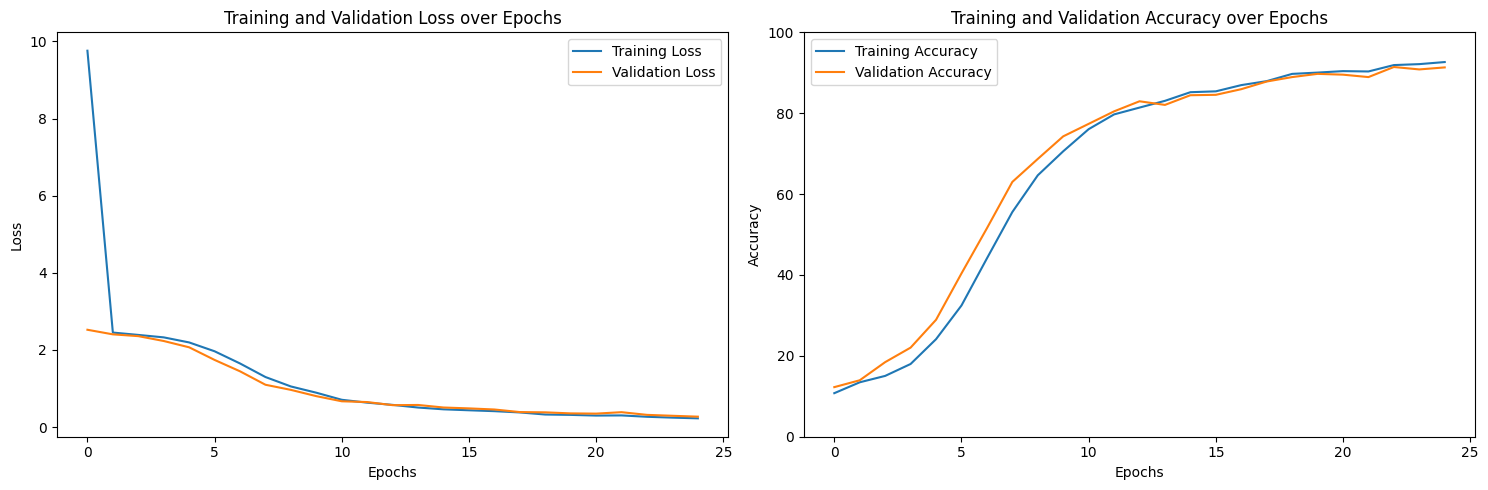

In [88]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()
     